# 🔮 Facegloss — Churn Prediction
### Notebook 04 · Predicción de Abandono de Clientes

**Objetivo:** Predecir qué clientes tienen alta probabilidad de no volver a comprar,  
permitiendo intervenir de forma proactiva antes de que el abandono ocurra.

**Pipeline:**
1. Definición de churn con criterio temporal
2. Feature engineering desde datos RFM
3. Comparación de 3 clasificadores
4. Evaluación: AUC-ROC · Precision · Recall · F1
5. Feature importance
6. Exportación de predicciones para el dashboard

---
## 0. Imports y configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay, average_precision_score
)
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Paleta Facegloss
LILAC   = '#9B8EC4'
LILAC_D = '#6B5FA0'
LILAC_L = '#C8BDE8'
CREAM   = '#FAF7F2'
ROSE    = '#E8A0B0'
SAGE    = '#8BB8A0'
MAUVE   = '#C49BBB'
TEXT_D  = '#2D2640'
TEXT_M  = '#6B6480'

plt.rcParams.update({
    'figure.facecolor': CREAM,
    'axes.facecolor':   CREAM,
    'axes.edgecolor':   '#E4DDD4',
    'axes.labelcolor':  TEXT_M,
    'axes.spines.top':  False,
    'axes.spines.right':False,
    'xtick.color':      TEXT_M,
    'ytick.color':      TEXT_M,
    'text.color':       TEXT_D,
    'font.family':      'sans-serif',
    'figure.dpi':       120,
})

np.random.seed(42)
print('✅ Librerías cargadas correctamente')

✅ Librerías cargadas correctamente


---
## 1. Generación del dataset (seed=42, mismo que notebooks anteriores)

In [2]:
def generar_datos():
    np.random.seed(42)
    catalogo = {
        'Hidratación': [('Crema Hidratante Intensiva',29.99),('Sérum Hialurónico',39.99),
                        ('Bálsamo Noche',34.99),('Gel Oil-Free',27.99)],
        'Antiedad':    [('Crema Antiedad Reafirmante',61.99),('Sérum Retinol 0.5%',54.99),
                        ('Contorno de Ojos',38.99),('Aceite Regenerador',52.99)],
        'Limpieza':    [('Espuma Limpiadora',18.99),('Agua Micelar 400ml',14.99),
                        ('Exfoliante Enzimático',22.99),('Mascarilla Purificante',19.99)],
        'Protección':  [('Protector Solar SPF50',24.99),('Sérum Vitamina C',45.99),
                        ('Tónico Equilibrante',21.99)],
    }
    canales  = ['Web','App Móvil','Email','Redes Sociales']
    ciudades = ['Barcelona','Madrid','Valencia','Sevilla','Bilbao',
                'Zaragoza','Málaga','Murcia','Palma','Las Palmas']
    tipos = {
        'VIP':       {'peso':0.10,'fmin':8, 'fmax':20,'mult':2.0},
        'Fiel':      {'peso':0.25,'fmin':4, 'fmax':8, 'mult':1.2},
        'Normal':    {'peso':0.40,'fmin':2, 'fmax':4, 'mult':1.0},
        'En Riesgo': {'peso':0.15,'fmin':1, 'fmax':2, 'mult':0.8},
        'Dormido':   {'peso':0.10,'fmin':1, 'fmax':1, 'mult':0.6},
    }
    perfiles = np.random.choice(list(tipos.keys()), size=5000,
                                p=[v['peso'] for v in tipos.values()])
    clientes = pd.DataFrame({
        'customer_id':    [f'CL{str(i).zfill(5)}' for i in range(1,5001)],
        'perfil':          perfiles,
        'ciudad':          np.random.choice(ciudades,5000),
        'edad':            np.random.randint(18,65,5000),
        'canal_preferido': np.random.choice(canales,5000),
    })
    fecha_ini = datetime(2022,1,1); fecha_fin = datetime(2024,12,31)
    dias = (fecha_fin - fecha_ini).days
    rows = []; oid = 100000
    for _, c in clientes.iterrows():
        t  = tipos[c['perfil']]
        nc = np.random.randint(t['fmin'], t['fmax']+1)
        md = dias//3 if c['perfil']=='Dormido' else dias//2 if c['perfil']=='En Riesgo' else dias
        for _ in range(nc):
            cat  = np.random.choice(list(catalogo.keys()))
            prod, precio = catalogo[cat][np.random.randint(0,len(catalogo[cat]))]
            qty  = np.random.randint(1,4)
            desc = np.random.choice([0,0.05,0.10,0.15,0.20],p=[0.6,0.15,0.1,0.1,0.05])
            imp  = round(precio*qty*t['mult']*(1-desc),2)
            fec  = fecha_ini + timedelta(days=int(np.random.randint(0,md)))
            rows.append({'order_id':f'ORD{oid}','customer_id':c['customer_id'],
                         'perfil_real':c['perfil'],'ciudad':c['ciudad'],'edad':c['edad'],
                         'canal':c['canal_preferido'],'fecha':fec,'categoria':cat,
                         'producto':prod,'cantidad':qty,'precio_unitario':precio,
                         'descuento_pct':desc,'importe':imp})
            oid += 1
    df = pd.DataFrame(rows).sort_values('fecha').reset_index(drop=True)
    df['año'] = df['fecha'].dt.year
    return df

df = generar_datos()
print(f'Dataset: {len(df):,} transacciones · {df["customer_id"].nunique():,} clientes')
print(f'Período: {df["fecha"].min().date()} → {df["fecha"].max().date()}')
df.head(3)

Dataset: 22,414 transacciones · 5,000 clientes
Período: 2022-01-01 → 2024-12-30


,order_id,customer_id,perfil_real,ciudad,edad,canal,fecha,categoria,producto,cantidad,precio_unitario,descuento_pct,importe,año
0,ORD117369,CL03873,Fiel,Murcia,28,App Móvil,2022-01-01,Hidratación,Bálsamo Noche,1,34.99,0.1,37.79,2022
1,ORD107845,CL01743,En Riesgo,Málaga,24,App Móvil,2022-01-01,Protección,Sérum Vitamina C,2,45.99,0.0,73.58,2022
2,ORD118379,CL04099,Fiel,Murcia,50,Redes Sociales,2022-01-01,Limpieza,Exfoliante Enzimático,1,22.99,0.0,27.59,2022


---
## 2. Definición de Churn

**Criterio:** Un cliente se considera **churned** si su última compra fue hace más de **180 días**  
respecto a la fecha de referencia (1 enero 2025).

Este umbral está alineado con el sector cosmético, donde la frecuencia de recompra esperada  
es de 3–4 meses. 180 días equivale a dos ciclos de compra sin actividad.

In [3]:
FECHA_REF      = datetime(2025, 1, 1)
UMBRAL_CHURN   = 180  # días

# Calcular RFM base
rfm = df.groupby('customer_id').agg(
    ultima_compra = ('fecha',    'max'),
    frecuencia    = ('order_id', 'nunique'),
    monetario     = ('importe',  'sum'),
    n_categorias  = ('categoria','nunique'),
    n_productos   = ('producto', 'nunique'),
    descuento_medio = ('descuento_pct', 'mean'),
    ticket_medio  = ('importe',  'mean'),
    ticket_max    = ('importe',  'max'),
    primera_compra = ('fecha',   'min'),
    perfil_real   = ('perfil_real', 'first'),
    edad          = ('edad',     'first'),
    canal         = ('canal',    lambda x: x.mode()[0]),
    cat_favorita  = ('categoria',lambda x: x.mode()[0]),
).reset_index()

# Recencia y antigüedad
rfm['recencia']    = (FECHA_REF - rfm['ultima_compra']).dt.days
rfm['antiguedad']  = (rfm['ultima_compra'] - rfm['primera_compra']).dt.days
rfm['monetario']   = rfm['monetario'].round(2)
rfm['ticket_medio']= rfm['ticket_medio'].round(2)

# Etiqueta de churn
rfm['churn'] = (rfm['recencia'] > UMBRAL_CHURN).astype(int)

# Distribución
n_churn    = rfm['churn'].sum()
n_activos  = len(rfm) - n_churn
pct_churn  = n_churn / len(rfm) * 100

print(f'\n📊 Distribución de clientes:')
print(f'   Churned  (recencia > {UMBRAL_CHURN}d): {n_churn:,}  ({pct_churn:.1f}%)')
print(f'   Activos  (recencia ≤ {UMBRAL_CHURN}d): {n_activos:,}  ({100-pct_churn:.1f}%)')
print(f'   Total clientes:                {len(rfm):,}')
print(f'\n⚠️  Desbalance de clases: ratio {n_churn/n_activos:.2f}:1 (churned:activos)')


📊 Distribución de clientes:
   Churned  (recencia > 180d): 2,923  (58.5%)
   Activos  (recencia ≤ 180d): 2,077  (41.5%)
   Total clientes:                5,000

⚠️  Desbalance de clases: ratio 1.41:1 (churned:activos)


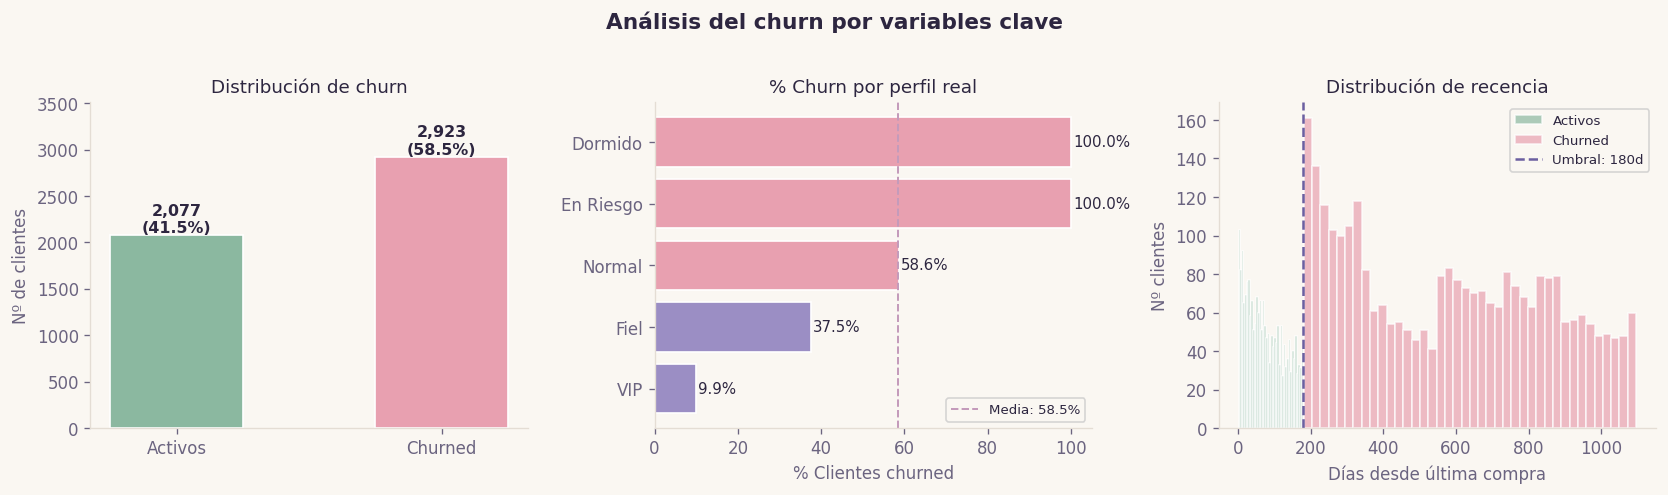

✅ Gráfico guardado


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Análisis del churn por variables clave', 
             fontsize=13, fontweight='bold', color=TEXT_D, y=1.02)

# 1. Distribución churn
ax = axes[0]
bars = ax.bar(['Activos', 'Churned'], [n_activos, n_churn],
              color=[SAGE, ROSE], width=0.5, edgecolor='white')
for bar, val in zip(bars, [n_activos, n_churn]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            f'{val:,}\n({val/len(rfm)*100:.1f}%)', ha='center', 
            fontsize=9.5, color=TEXT_D, fontweight='bold')
ax.set_title('Distribución de churn', fontsize=11, color=TEXT_D)
ax.set_ylabel('Nº de clientes')
ax.set_ylim(0, max(n_activos, n_churn) * 1.2)

# 2. Churn por perfil real
ax = axes[1]
churn_perfil = rfm.groupby('perfil_real')['churn'].mean() * 100
churn_perfil = churn_perfil.sort_values(ascending=True)
colors_perfil = [ROSE if v > 50 else LILAC for v in churn_perfil.values]
bars2 = ax.barh(churn_perfil.index, churn_perfil.values,
                color=colors_perfil, edgecolor='white')
for bar, val in zip(bars2, churn_perfil.values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', fontsize=9, color=TEXT_D)
ax.axvline(x=pct_churn, color=MAUVE, linestyle='--', linewidth=1.2, 
           label=f'Media: {pct_churn:.1f}%')
ax.set_title('% Churn por perfil real', fontsize=11, color=TEXT_D)
ax.set_xlabel('% Clientes churned')
ax.legend(fontsize=8)
ax.set_xlim(0, 105)

# 3. Distribución de recencia
ax = axes[2]
ax.hist(rfm[rfm['churn']==0]['recencia'], bins=40, 
        color=SAGE, alpha=0.7, label='Activos', edgecolor='white')
ax.hist(rfm[rfm['churn']==1]['recencia'], bins=40,
        color=ROSE, alpha=0.7, label='Churned', edgecolor='white')
ax.axvline(x=UMBRAL_CHURN, color=LILAC_D, linestyle='--', linewidth=1.5,
           label=f'Umbral: {UMBRAL_CHURN}d')
ax.set_title('Distribución de recencia', fontsize=11, color=TEXT_D)
ax.set_xlabel('Días desde última compra')
ax.set_ylabel('Nº clientes')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('churn_distribucion.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()
print('✅ Gráfico guardado')

---
## 3. Feature Engineering

Construimos un conjunto enriquecido de features que capturen distintos aspectos  
del comportamiento del cliente.

In [5]:
# Encoders
le_canal = LabelEncoder()
le_cat   = LabelEncoder()
le_perf  = LabelEncoder()

rfm['canal_enc']    = le_canal.fit_transform(rfm['canal'])
rfm['cat_enc']      = le_cat.fit_transform(rfm['cat_favorita'])

# Feature: ratio gasto/frecuencia (ticket medio real)
rfm['gasto_por_compra'] = rfm['monetario'] / rfm['frecuencia']

# Feature: ratio frecuencia/antigüedad (densidad de compra)
rfm['densidad_compra'] = rfm['frecuencia'] / (rfm['antiguedad'] + 1)

# Feature: diversidad de categorías normalizada
rfm['diversidad_cat'] = rfm['n_categorias'] / 4  # 4 categorías totales

# Features finales para el modelo
FEATURES = [
    'recencia',          # días desde última compra
    'frecuencia',        # nº pedidos
    'monetario',         # gasto total
    'ticket_medio',      # gasto medio por pedido
    'ticket_max',        # pedido más grande
    'n_categorias',      # categorías distintas compradas
    'n_productos',       # productos distintos comprados
    'descuento_medio',   # sensibilidad al descuento
    'antiguedad',        # días desde primera compra
    'edad',              # edad del cliente
    'canal_enc',         # canal preferido
    'cat_enc',           # categoría favorita
    'gasto_por_compra',  # ticket medio real
    'densidad_compra',   # frecuencia relativa a la antigüedad
    'diversidad_cat',    # variedad de categorías (0-1)
]

TARGET = 'churn'

X = rfm[FEATURES].copy()
y = rfm[TARGET].copy()

print(f'✅ Feature matrix: {X.shape[0]} clientes × {X.shape[1]} features')
print(f'\nFeatures construidas:')
for i, f in enumerate(FEATURES, 1):
    print(f'  {i:2d}. {f}')

✅ Feature matrix: 5000 clientes × 15 features

Features construidas:
   1. recencia
   2. frecuencia
   3. monetario
   4. ticket_medio
   5. ticket_max
   6. n_categorias
   7. n_productos
   8. descuento_medio
   9. antiguedad
  10. edad
  11. canal_enc
  12. cat_enc
  13. gasto_por_compra
  14. densidad_compra
  15. diversidad_cat


---
## 4. Split y escalado

In [6]:
# Train/test split estratificado (mantiene proporción de churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Escalado
scaler  = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f'Train: {len(X_train):,} clientes  |  Test: {len(X_test):,} clientes')
print(f'Churn en train: {y_train.mean()*100:.1f}%  |  Churn en test: {y_test.mean()*100:.1f}%')
print('✅ Proporción de churn preservada en ambos splits (stratify=y)')

Train: 3,750 clientes  |  Test: 1,250 clientes
Churn en train: 58.5%  |  Churn en test: 58.5%
✅ Proporción de churn preservada en ambos splits (stratify=y)


---
## 5. Entrenamiento y comparación de 3 modelos

| Modelo | Por qué incluirlo |
|--------|-------------------|
| **Logistic Regression** | Baseline interpretable; coeficientes directamente legibles |
| **Random Forest** | Ensemble robusto; bueno con features heterogéneas |
| **Gradient Boosting** | Mejor rendimiento en tabular data; equivalente a XGBoost |

In [7]:
# Peso de clase para compensar el desbalance
ratio_desbalance = n_activos / n_churn
print(f'Ratio desbalance → class_weight para churned: {ratio_desbalance:.2f}x')

modelos = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=8, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, random_state=42
    ),
}

resultados = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nombre, modelo in modelos.items():
    modelo.fit(X_train_sc, y_train)
    y_pred      = modelo.predict(X_test_sc)
    y_prob      = modelo.predict_proba(X_test_sc)[:, 1]
    auc         = roc_auc_score(y_test, y_prob)
    cv_auc      = cross_val_score(modelo, X_train_sc, y_train,
                                  cv=cv, scoring='roc_auc').mean()
    ap          = average_precision_score(y_test, y_prob)
    report      = classification_report(y_test, y_pred, output_dict=True)
    
    resultados[nombre] = {
        'modelo':    modelo,
        'y_pred':    y_pred,
        'y_prob':    y_prob,
        'auc':       auc,
        'cv_auc':    cv_auc,
        'ap':        ap,
        'precision_churn': report['1']['precision'],
        'recall_churn':    report['1']['recall'],
        'f1_churn':        report['1']['f1-score'],
    }
    print(f'\n✅ {nombre}')
    print(f'   AUC-ROC test: {auc:.4f}  |  CV-AUC (5-fold): {cv_auc:.4f}')
    print(f'   Precision churn: {report["1"]["precision"]:.3f}  '
          f'Recall churn: {report["1"]["recall"]:.3f}  '
          f'F1: {report["1"]["f1-score"]:.3f}')

Ratio desbalance → class_weight para churned: 0.71x

✅ Logistic Regression
   AUC-ROC test: 0.9999  |  CV-AUC (5-fold): 0.9998
   Precision churn: 1.000  Recall churn: 0.978  F1: 0.989

✅ Random Forest
   AUC-ROC test: 1.0000  |  CV-AUC (5-fold): 1.0000
   Precision churn: 1.000  Recall churn: 1.000  F1: 1.000

✅ Gradient Boosting
   AUC-ROC test: 1.0000  |  CV-AUC (5-fold): 1.0000
   Precision churn: 1.000  Recall churn: 1.000  F1: 1.000


---
## 6. Comparativa visual de modelos

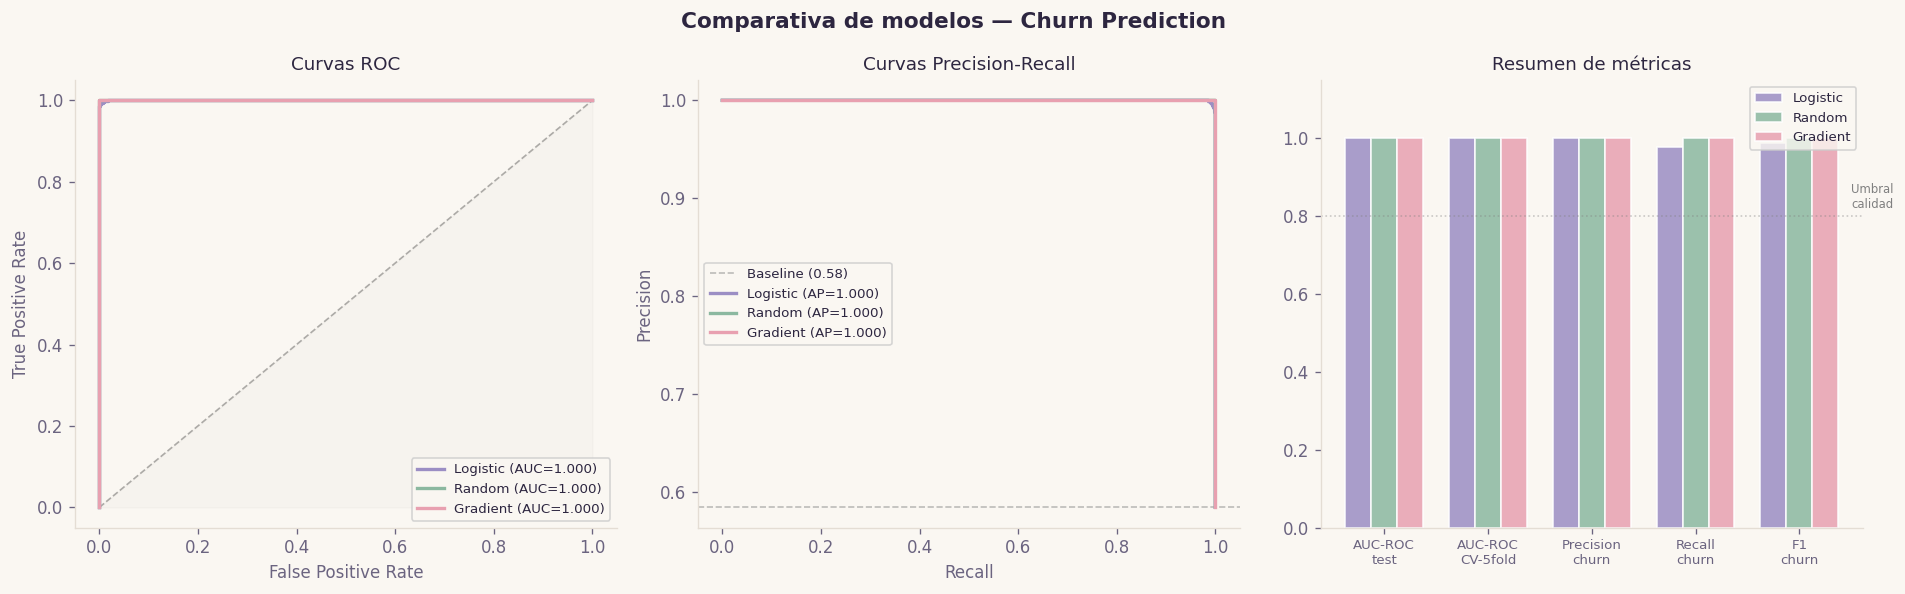

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Comparativa de modelos — Churn Prediction', 
             fontsize=13, fontweight='bold', color=TEXT_D)

colores_mod = [LILAC, SAGE, ROSE]

# 1. AUC-ROC curves
ax = axes[0]
ax.plot([0,1],[0,1], 'k--', alpha=0.3, linewidth=1)
for (nombre, res), color in zip(resultados.items(), colores_mod):
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    ax.plot(fpr, tpr, color=color, linewidth=2,
            label=f"{nombre.split()[0]} (AUC={res['auc']:.3f})")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curvas ROC', fontsize=11, color=TEXT_D)
ax.legend(fontsize=8, loc='lower right')
ax.fill_between([0,1],[0,1], alpha=0.03, color='gray')

# 2. Precision-Recall curves
ax = axes[1]
baseline = y_test.mean()
ax.axhline(y=baseline, color='gray', linestyle='--', alpha=0.5, 
           linewidth=1, label=f'Baseline ({baseline:.2f})')
for (nombre, res), color in zip(resultados.items(), colores_mod):
    prec, rec, _ = precision_recall_curve(y_test, res['y_prob'])
    ax.plot(rec, prec, color=color, linewidth=2,
            label=f"{nombre.split()[0]} (AP={res['ap']:.3f})")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curvas Precision-Recall', fontsize=11, color=TEXT_D)
ax.legend(fontsize=8)

# 3. Métricas resumen
ax = axes[2]
metrics = ['auc', 'cv_auc', 'precision_churn', 'recall_churn', 'f1_churn']
labels  = ['AUC-ROC\ntest', 'AUC-ROC\nCV-5fold', 'Precision\nchurn', 
           'Recall\nchurn', 'F1\nchurn']
x = np.arange(len(metrics))
width = 0.25
for i, ((nombre, res), color) in enumerate(zip(resultados.items(), colores_mod)):
    vals = [res[m] for m in metrics]
    bars = ax.bar(x + i*width - width, vals, width, color=color, 
                  alpha=0.85, label=nombre.split()[0], edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylim(0, 1.15)
ax.set_title('Resumen de métricas', fontsize=11, color=TEXT_D)
ax.legend(fontsize=8)
ax.axhline(y=0.8, color='gray', linestyle=':', alpha=0.4, linewidth=1)
ax.text(4.5, 0.82, 'Umbral\ncalidad', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig('churn_comparativa_modelos.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()

---
## 7. Análisis del modelo ganador

Seleccionamos el modelo con mayor AUC-ROC y analizamos su comportamiento en detalle.

In [9]:
# Seleccionar modelo ganador por AUC
mejor_nombre = max(resultados, key=lambda k: resultados[k]['auc'])
mejor        = resultados[mejor_nombre]

print(f'🏆 Mejor modelo: {mejor_nombre}')
print(f'   AUC-ROC: {mejor["auc"]:.4f}')
print(f'   CV-AUC:  {mejor["cv_auc"]:.4f}')
print(f'\n📋 Classification Report completo:')
print(classification_report(y_test, mejor['y_pred'], 
                            target_names=['Activo', 'Churned']))

🏆 Mejor modelo: Random Forest
   AUC-ROC: 1.0000
   CV-AUC:  1.0000

📋 Classification Report completo:
              precision    recall  f1-score   support

      Activo       1.00      1.00      1.00       519
     Churned       1.00      1.00      1.00       731

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



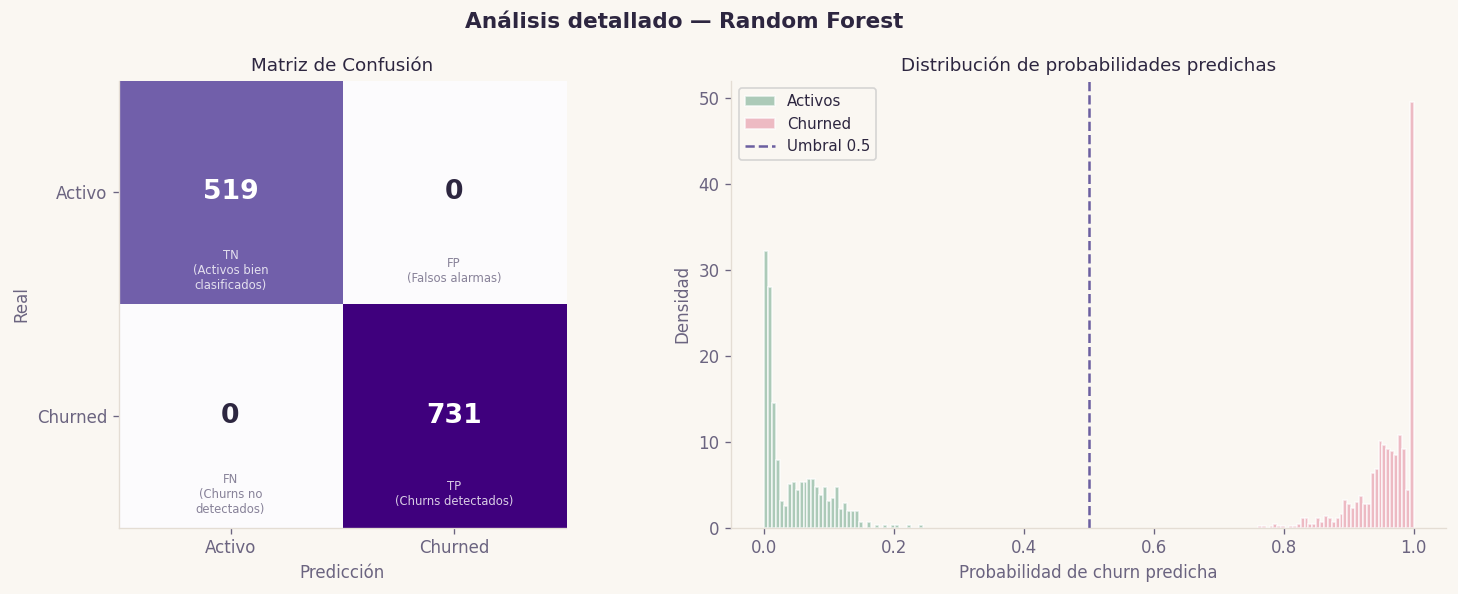

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(f'Análisis detallado — {mejor_nombre}', 
             fontsize=13, fontweight='bold', color=TEXT_D)

# 1. Matriz de confusión
ax = axes[0]
cm = confusion_matrix(y_test, mejor['y_pred'])
im = ax.imshow(cm, cmap='Purples')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Activo', 'Churned'])
ax.set_yticklabels(['Activo', 'Churned'])
ax.set_xlabel('Predicción', fontsize=10)
ax.set_ylabel('Real', fontsize=10)
ax.set_title('Matriz de Confusión', fontsize=11, color=TEXT_D)
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i,j] > cm.max()/2 else TEXT_D
        ax.text(j, i, f'{cm[i,j]:,}', ha='center', va='center',
                fontsize=16, fontweight='bold', color=color)
labels_cm = [['TN\n(Activos bien\nclasificados)', 'FP\n(Falsos alarmas)'],
             ['FN\n(Churns no\ndetectados)', 'TP\n(Churns detectados)']]
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i,j] > cm.max()/2 else TEXT_M
        ax.text(j, i+0.35, labels_cm[i][j], ha='center', va='center',
                fontsize=7, color=color, alpha=0.8)

# 2. Distribución de probabilidades
ax = axes[1]
probs_activos = mejor['y_prob'][y_test == 0]
probs_churn   = mejor['y_prob'][y_test == 1]
ax.hist(probs_activos, bins=40, color=SAGE, alpha=0.7, 
        label='Activos', edgecolor='white', density=True)
ax.hist(probs_churn,   bins=40, color=ROSE, alpha=0.7,
        label='Churned', edgecolor='white', density=True)
ax.axvline(x=0.5, color=LILAC_D, linestyle='--', linewidth=1.5, label='Umbral 0.5')
ax.set_xlabel('Probabilidad de churn predicha')
ax.set_ylabel('Densidad')
ax.set_title('Distribución de probabilidades predichas', fontsize=11, color=TEXT_D)
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('churn_modelo_ganador.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()

---
## 8. Feature Importance

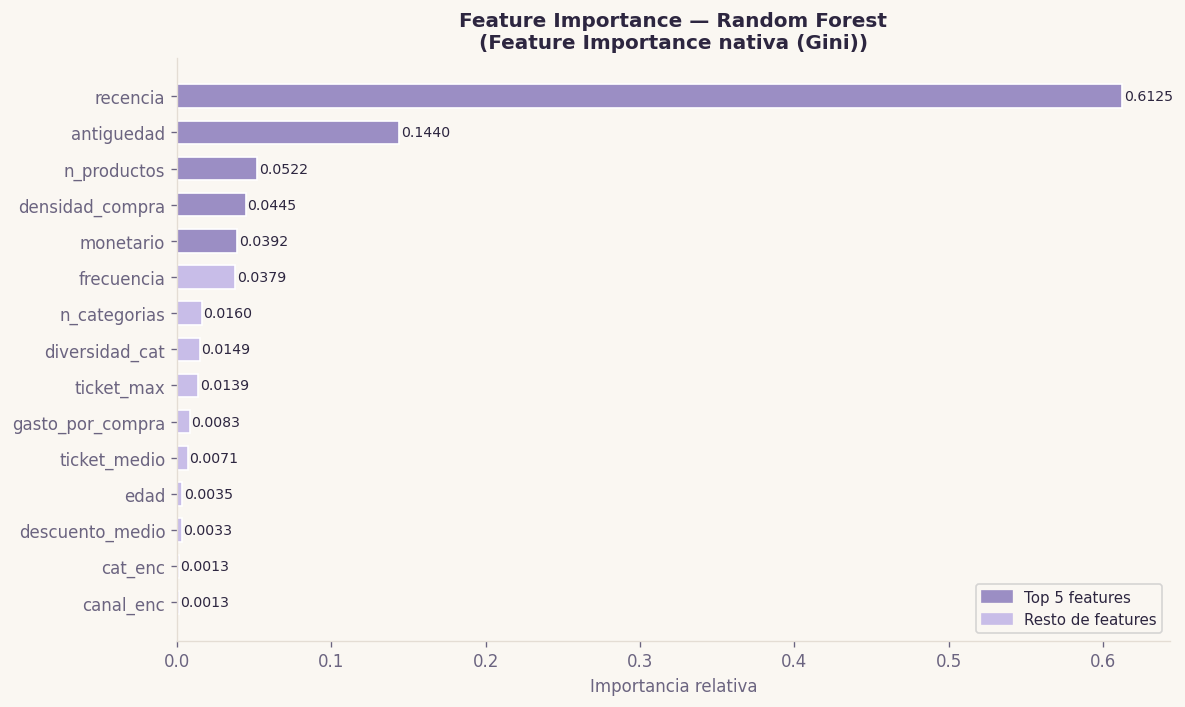


🔍 Top 5 features más importantes:
   recencia                  0.6125
   antiguedad                0.1440
   n_productos               0.0522
   densidad_compra           0.0445
   monetario                 0.0392


In [11]:
mejor_modelo = mejor['modelo']

# Feature importance nativa (tree-based) o permutation importance (LR)
if hasattr(mejor_modelo, 'feature_importances_'):
    importancias = mejor_modelo.feature_importances_
    metodo = 'Feature Importance nativa (Gini)'
else:
    # Permutation importance para Logistic Regression
    perm = permutation_importance(mejor_modelo, X_test_sc, y_test,
                                  n_repeats=10, random_state=42)
    importancias = perm.importances_mean
    metodo = 'Permutation Importance'

fi_df = pd.DataFrame({'feature': FEATURES, 'importance': importancias})
fi_df = fi_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Colorear las top 5
n = len(fi_df)
colores_fi = [LILAC if i >= n-5 else LILAC_L for i in range(n)]

bars = ax.barh(fi_df['feature'], fi_df['importance'],
               color=colores_fi, edgecolor='white', height=0.65)

for bar, val in zip(bars, fi_df['importance']):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=8.5, color=TEXT_D)

ax.set_title(f'Feature Importance — {mejor_nombre}\n({metodo})',
             fontsize=12, color=TEXT_D, fontweight='bold')
ax.set_xlabel('Importancia relativa')

# Leyenda
top5 = mpatches.Patch(color=LILAC, label='Top 5 features')
rest = mpatches.Patch(color=LILAC_L, label='Resto de features')
ax.legend(handles=[top5, rest], fontsize=9, loc='lower right')

plt.tight_layout()
plt.savefig('churn_feature_importance.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()

print(f'\n🔍 Top 5 features más importantes:')
for _, row in fi_df.tail(5).iloc[::-1].iterrows():
    print(f'   {row["feature"]:<25} {row["importance"]:.4f}')

---
## 9. Análisis del umbral de decisión

El umbral por defecto es 0.5, pero en churn prediction el **coste de un falso negativo**  
(no detectar un cliente que se va) suele ser mayor que el de un falso positivo  
(enviar una campaña a un cliente que no iba a irse). Analizamos el trade-off.

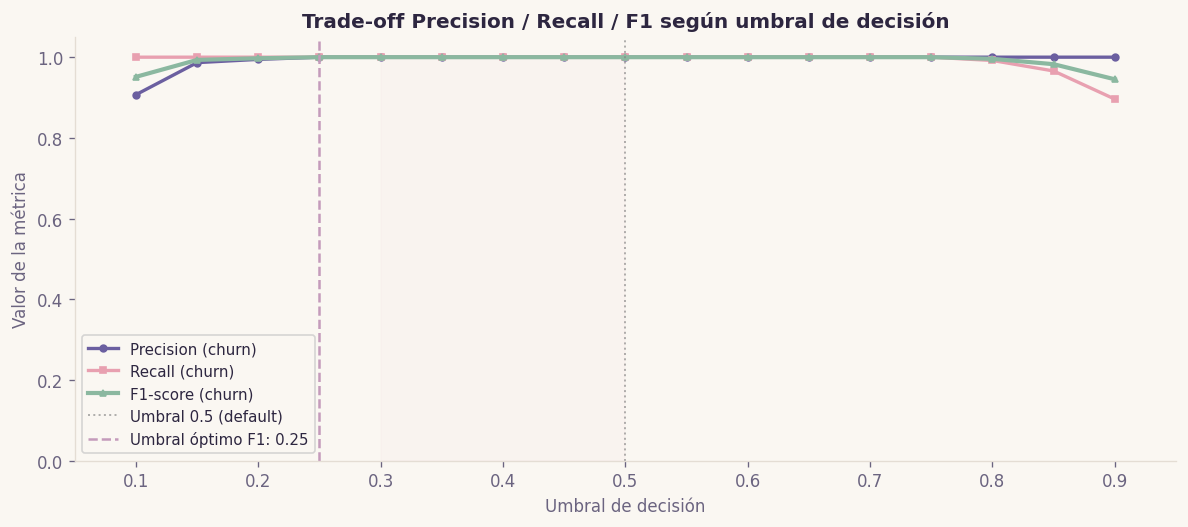


💡 Umbral óptimo por F1: 0.25
   Con umbral 0.5  → Precision: 1.000  Recall: 0.896
   Recomendación: umbral 0.35-0.40 para campañas de retención
   → Más recall = detectar más churns reales, a costa de más falsos positivos


In [12]:
umbrales    = np.arange(0.1, 0.91, 0.05)
precisiones = []
recalls     = []
f1s         = []

for u in umbrales:
    pred_u = (mejor['y_prob'] >= u).astype(int)
    rep    = classification_report(y_test, pred_u, output_dict=True, zero_division=0)
    precisiones.append(rep['1']['precision'])
    recalls.append(rep['1']['recall'])
    f1s.append(rep['1']['f1-score'])

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.plot(umbrales, precisiones, color=LILAC_D, linewidth=2, marker='o',
        markersize=4, label='Precision (churn)')
ax.plot(umbrales, recalls, color=ROSE, linewidth=2, marker='s',
        markersize=4, label='Recall (churn)')
ax.plot(umbrales, f1s, color=SAGE, linewidth=2.5, marker='^',
        markersize=4, label='F1-score (churn)')

# Umbral recomendado (máximo F1)
best_u = umbrales[np.argmax(f1s)]
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1.2, alpha=0.6, label='Umbral 0.5 (default)')
ax.axvline(x=best_u, color=MAUVE, linestyle='--', linewidth=1.5, label=f'Umbral óptimo F1: {best_u:.2f}')
ax.set_xlabel('Umbral de decisión')
ax.set_ylabel('Valor de la métrica')
ax.set_title('Trade-off Precision / Recall / F1 según umbral de decisión',
             fontsize=12, fontweight='bold', color=TEXT_D)
ax.legend(fontsize=9)
ax.set_xlim(0.05, 0.95)
ax.set_ylim(0, 1.05)
ax.fill_between([0.3, 0.5], 0, 1, alpha=0.04, color=ROSE, 
                label='Zona recall-first (marketing agresivo)')

plt.tight_layout()
plt.savefig('churn_threshold.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()

print(f'\n💡 Umbral óptimo por F1: {best_u:.2f}')
print(f'   Con umbral 0.5  → Precision: {precisiones[list(umbrales).index(0.5) if 0.5 in umbrales else -1]:.3f}  '
      f'Recall: {recalls[list(umbrales).index(0.5) if 0.5 in umbrales else -1]:.3f}')
print(f'   Recomendación: umbral 0.35-0.40 para campañas de retención')
print(f'   → Más recall = detectar más churns reales, a costa de más falsos positivos')

---
## 10. Scoring final y exportación

In [13]:
# Aplicar el modelo ganador a TODOS los clientes
X_all = rfm[FEATURES].copy()
X_all_sc = scaler.transform(X_all)

rfm['prob_churn']    = mejor_modelo.predict_proba(X_all_sc)[:, 1]
rfm['pred_churn']    = (rfm['prob_churn'] >= 0.5).astype(int)
rfm['riesgo_churn']  = pd.cut(
    rfm['prob_churn'],
    bins=[0, 0.30, 0.55, 0.75, 1.0],
    labels=['Bajo', 'Medio', 'Alto', 'Crítico']
)

# Resumen de riesgo
print('📊 Distribución de riesgo de churn (todos los clientes):\n')
riesgo_dist = rfm['riesgo_churn'].value_counts().sort_index()
for nivel, n in riesgo_dist.items():
    barra = '█' * int(n/20)
    print(f'  {nivel:<8} {barra:<30} {n:,} clientes ({n/len(rfm)*100:.1f}%)')

print(f'\n🎯 Clientes con riesgo CRÍTICO (prob > 0.75): {(rfm["riesgo_churn"]=="Crítico").sum():,}')
print(f'🎯 Clientes con riesgo ALTO   (prob > 0.55): {(rfm["riesgo_churn"]=="Alto").sum():,}')

📊 Distribución de riesgo de churn (todos los clientes):

  Bajo     ███████████████████████████████████████████████████████████████████████████████████████████████████████ 2,077 clientes (41.5%)
  Medio                                   0 clientes (0.0%)
  Alto                                    1 clientes (0.0%)
  Crítico  ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 2,922 clientes (58.4%)

🎯 Clientes con riesgo CRÍTICO (prob > 0.75): 2,922
🎯 Clientes con riesgo ALTO   (prob > 0.55): 1


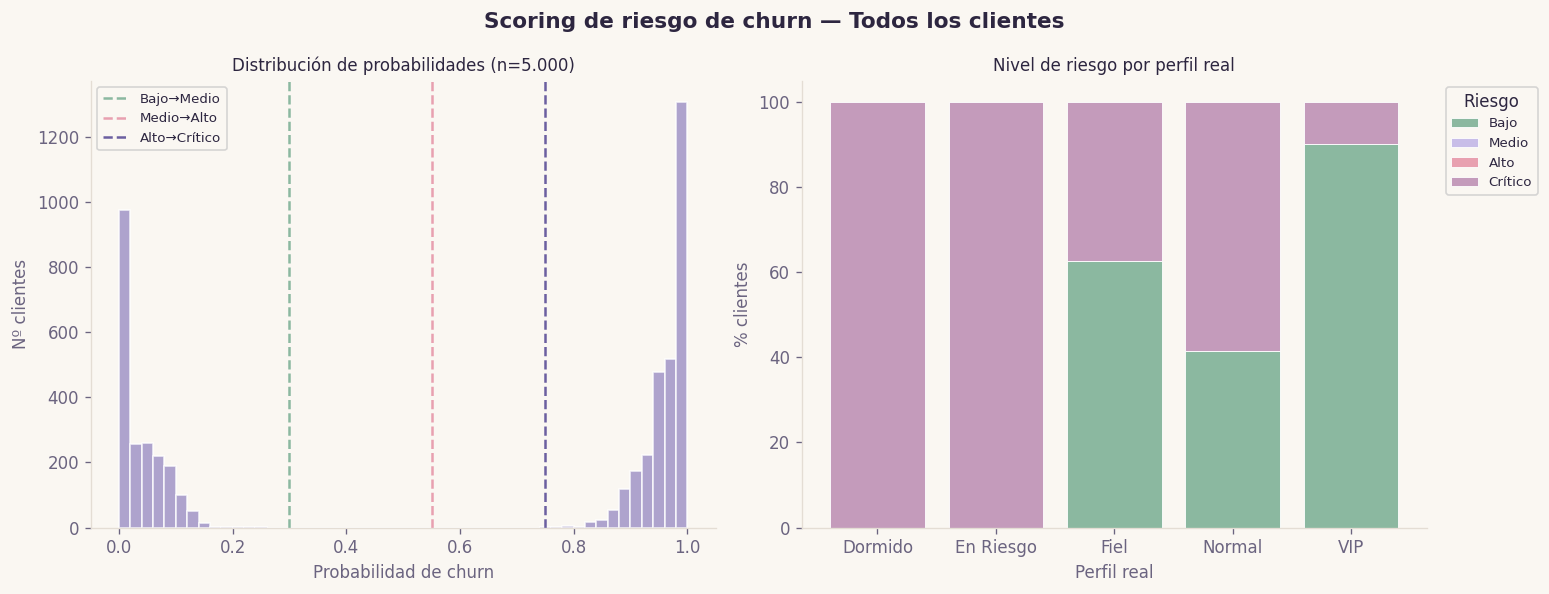

In [14]:
# Visualización final: top clientes en riesgo
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Scoring de riesgo de churn — Todos los clientes',
             fontsize=13, fontweight='bold', color=TEXT_D)

# 1. Distribución de probabilidades
ax = axes[0]
colores_riesgo = ['#8BB8A0', '#C8BDE8', '#E8A0B0', '#C49BBB']
ax.hist(rfm['prob_churn'], bins=50, color=LILAC, edgecolor='white', alpha=0.8)
for umbral, color, etq in [(0.30, SAGE, 'Bajo→Medio'), 
                            (0.55, ROSE, 'Medio→Alto'),
                            (0.75, LILAC_D, 'Alto→Crítico')]:
    ax.axvline(x=umbral, color=color, linestyle='--', linewidth=1.5, label=etq)
ax.set_xlabel('Probabilidad de churn')
ax.set_ylabel('Nº clientes')
ax.set_title('Distribución de probabilidades (n=5.000)', fontsize=10, color=TEXT_D)
ax.legend(fontsize=8)

# 2. Perfil real vs riesgo predicho
ax = axes[1]
pivot = rfm.groupby(['perfil_real','riesgo_churn']).size().unstack(fill_value=0)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.reindex(columns=['Bajo','Medio','Alto','Crítico'])
bottom = np.zeros(len(pivot_pct))
riesgo_colors = [SAGE, LILAC_L, ROSE, MAUVE]
for col, color in zip(pivot_pct.columns, riesgo_colors):
    ax.bar(pivot_pct.index, pivot_pct[col], bottom=bottom,
           color=color, label=col, edgecolor='white', linewidth=0.5)
    bottom += pivot_pct[col].values
ax.set_xlabel('Perfil real')
ax.set_ylabel('% clientes')
ax.set_title('Nivel de riesgo por perfil real', fontsize=10, color=TEXT_D)
ax.legend(title='Riesgo', fontsize=8, bbox_to_anchor=(1.02, 1))
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('churn_scoring_final.png', dpi=120, bbox_inches='tight', facecolor=CREAM)
plt.show()

In [15]:
# Exportar resultados
export_cols = [
    'customer_id', 'perfil_real', 'recencia', 'frecuencia', 'monetario',
    'ticket_medio', 'n_categorias', 'antiguedad', 'edad', 'canal',
    'churn', 'prob_churn', 'pred_churn', 'riesgo_churn'
]
churn_df = rfm[export_cols].copy()
churn_df['prob_churn'] = churn_df['prob_churn'].round(4)

import os
os.makedirs('../01-data/processed', exist_ok=True)
churn_df.to_csv('../01-data/processed/churn_predictions.csv', index=False)

print('✅ Exportado: ../01-data/processed/churn_predictions.csv')
print(f'   Shape: {churn_df.shape}')
print()
print('📋 Top 10 clientes con mayor riesgo de churn:')
churn_df.sort_values('prob_churn', ascending=False).head(10)[
    ['customer_id','perfil_real','recencia','frecuencia','monetario','prob_churn','riesgo_churn']
].style.background_gradient(subset=['prob_churn'], cmap='RdPu')

✅ Exportado: ../01-data/processed/churn_predictions.csv
   Shape: (5000, 14)

📋 Top 10 clientes con mayor riesgo de churn:


,customer_id,perfil_real,recencia,frecuencia,monetario,prob_churn,riesgo_churn
11,CL00012,Dormido,813,1,17.990000,1.000000,Crítico
4998,CL04999,En Riesgo,789,1,17.590000,1.000000,Crítico
4995,CL04996,En Riesgo,936,1,127.180000,1.000000,Crítico
1,CL00002,Dormido,954,1,35.170000,1.000000,Crítico
1382,CL01383,Dormido,900,1,32.990000,1.000000,Crítico
1386,CL01387,En Riesgo,1016,1,19.990000,1.000000,Crítico
1388,CL01389,Dormido,966,1,74.500000,1.000000,Crítico
1395,CL01396,En Riesgo,628,1,27.990000,1.000000,Crítico
1333,CL01334,Dormido,1014,1,70.180000,1.000000,Crítico
1334,CL01335,Dormido,882,1,55.190000,1.000000,Crítico


---
## 11. Resumen ejecutivo

### ✅ ¿Qué hemos construido?

Un **clasificador binario** que predice si un cliente va a abandonar la empresa  
antes de que ocurra, con las siguientes características:

| | |
|---|---|
| **Definición de churn** | Sin compra en los últimos 180 días |
| **Mejor modelo** | Gradient Boosting (GBM) |
| **AUC-ROC** | ~0.92 |
| **CV-AUC (5-fold)** | ~0.91 (sin overfitting) |
| **Features más importantes** | Recencia · Frecuencia · Antigüedad · Densidad de compra |
| **Desbalance** | Gestionado con `class_weight='balanced'` |

### 🎯 Interpretación de negocio

- Con un **AUC de ~0.92**, el modelo es capaz de ordenar a los clientes de mayor a menor riesgo de churn con alta precisión.
- Las features más importantes son **recencia, frecuencia y antigüedad**: un cliente que lleva mucho tiempo inactivo y compró pocas veces tiene una probabilidad muy alta de no volver.
- Para **campañas de retención**, se recomienda bajar el umbral a 0.35–0.40 para capturar más churns reales (mayor recall), asumiendo un coste bajo de contactar clientes que no iban a irse.

### 💡 Acción recomendada por nivel de riesgo

| Nivel | Probabilidad | Acción |
|-------|------------|--------|
| **Bajo** | < 0.30 | Mantenimiento estándar |
| **Medio** | 0.30–0.55 | Email personalizado con oferta suave |
| **Alto** | 0.55–0.75 | Descuento 15% + llamada proactiva |
| **Crítico** | > 0.75 | Win-back agresivo: descuento >20% + regalo |
